# <center><u>NYC Parking Violation Case Study</center></u>

# <u>Problem Statement:

Big data analytics allows you to analyse data at scale. It has applications in almost every industry in the world. Let’s consider an unconventional application that you wouldn’t ordinarily encounter.

New York City is a thriving metropolis. Just like most other metros its size, one of the biggest problems its citizens face is parking. The classic combination of a huge number of cars and cramped geography leads to a huge number of parking tickets.

In an attempt to scientifically analyse this phenomenon, the NYC Police Department has **collected data for parking tickets**. Of these, the data files for multiple years are publicly available on Kaggle. We will try and perform some **exploratory analysis** on a part of this data. Spark will allow us to analyse the full files at high speeds as opposed to taking a series of random samples that will approximate the population. For the scope of this analysis, we will analyse the parking tickets over the year **2017**.

The purpose of this case study is to conduct an exploratory data analysis that will help you understand the data.

##### Creating Spark Session:

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("NYC Parking") \
    .getOrCreate()

In [3]:
spark

##### Reading the Data Set:

In [4]:
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")

##### Observing top 5 rows of the dataframe:

In [5]:
df.show(5, False)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|5092469481    |GZH7067 |NY                |07/10/2016|7             |SUBN             |TOYOT       |0                 |0              |0143A         |
|5092451658    |GZH7067 |NY                |07/08/2016|7             |SUBN             |TOYOT       |0                 |0              |0400P         |
|4006265037    |FZX9232 |NY                |08/23/2016|5             |SUBN             |FORD        |0                 |0              |0233P         |
|8478629828    |66623ME |NY                |06/14/2017|47            |REFG             |

##### Getting information about total columns of the Dataframe:

In [6]:
df.columns

['Summons Number',
 'Plate ID',
 'Registration State',
 'Issue Date',
 'Violation Code',
 'Vehicle Body Type',
 'Vehicle Make',
 'Violation Precinct',
 'Issuer Precinct',
 'Violation Time']

##### Checking total number of columns:

In [7]:
len(df.columns)

10

So, there are 10 columns in the dataset in total.

##### Checking number of records:

In [8]:
df.count()

10803028

##### Fetching schema of the dataframe:

In [9]:
df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



We see that the column `Issue Date` is in string format. We'll change it to TimeStamp later.

##### Importing functions:

In [10]:
from pyspark.sql.functions import *

##### Checking Null Values in the dataframe:

In [11]:
df.select([count(when(isnan(c) | col(c).isNull(), True)).alias(c) for c in df.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|             0|       1|                 0|         0|             0|            42696|       73047|                 0|              0|            63|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



##### Checking some statistical information:

In [12]:
df.describe().toPandas()

,summary,Summons Number,Plate ID,Registration State,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Precinct,Issuer Precinct,Violation Time
0,count,10803028,10803027,10803028,10803028,10803028,10760333,10729981,10803028,10803028,10802965
1,mean,6.817447029065801E9,Infinity,99.0,None,34.599430455979565,NaN,6519.974025974026,45.01216260848347,46.82931211508477,909.2857142857143
2,stddev,2.3202339623282075E9,NaN,0.0,None,19.359868716323955,NaN,18091.257389147086,40.552560268436245,62.667035772695066,791.8453853409226
3,min,1002884949,#1MOM,99,01/01/2012,0,00,",FREI",0,0,.240P
4,max,8585600044,~,WY,12/31/2018,99,ZUHE,ken,933,997,8755P


##### Getting some more detailed statistical summary:

In [13]:
#df.summary().toPandas()

##### Modifying Column Names:
Let's put the `_` between 2 words of the column names so that it would be easier to call the columns as a single word name.

In [14]:
df = df.toDF(*(c.replace(' ', '_') for c in df.columns))
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|07/10/2016|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|07/08/2016|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|08/23/2016|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|06/14/2017|            47|             REFG|

##### Changing the type of `Issue_Date` from 'String' to Timestamp:

In [15]:
df = df.withColumn('Issue_Date', unix_timestamp(df['Issue_Date'], 'MM/dd/yyyy').cast('timestamp'))
df.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|         Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

##### Re-checking the schema now:

In [16]:
df.printSchema()

root
 |-- Summons_Number: long (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Issue_Date: timestamp (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Violation_Time: string (nullable = true)



## EDA:
I'll use pyspark.sql for further analysis:

##### Creating a view `parkingtable`:

In [17]:
df.createOrReplaceTempView('parkingTable')

##### Checking the top 5 records:

In [18]:
spark.sql("select * from parkingTable").show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|         Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

##### Checking year wise Violation Tickets counts:

In [19]:
spark.sql('select year(Issue_date) as Year, count(Summons_Number) as Total from Parkingtable group by Year order by Year').show(100)

+----+-------+
|Year|  Total|
+----+-------+
|1972|      2|
|1973|      2|
|1974|      1|
|1976|      1|
|1977|      1|
|1984|      1|
|1985|      1|
|1990|      2|
|1991|      3|
|1994|      1|
|1996|      1|
|1997|      1|
|2000|    185|
|2001|      2|
|2002|      1|
|2003|      1|
|2004|      2|
|2005|      1|
|2006|      8|
|2007|     18|
|2008|      4|
|2009|      3|
|2010|     48|
|2011|     22|
|2012|     87|
|2013|     70|
|2014|    120|
|2015|    419|
|2016|5368391|
|2017|5431918|
|2018|   1057|
|2019|    472|
|2020|     22|
|2021|     22|
|2022|      4|
|2023|      5|
|2024|      3|
|2025|      6|
|2026|     24|
|2027|     50|
|2028|      8|
|2029|      2|
|2030|     12|
|2031|      5|
|2033|      2|
|2036|      1|
|2041|      1|
|2047|      2|
|2053|      1|
|2060|      2|
|2061|      1|
|2062|      2|
|2063|      2|
|2068|      1|
|2069|      4|
+----+-------+



 - We see that the data set is mainly centered around year 2016 and 2017.
 - The year 2017 has most number of records, so I'll go with 2017 for further analysis.

##### Let's filter  the data to keep the record of the year 2017 only:
I'll use the this filtered record in this case study.

In [20]:
parking = spark.sql("select * from parkingtable where year(Issue_Date) == 2017")
parking.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|         Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14 00:00:00|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13 00:00:00|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
|    1407740258| 2513JMG|                NY|2017-01-11 00:00:00|            78|             DELV|       FRUEH|               106|            106|         0015A|
|    1413656420|T672371C|         

##### Creating a temp view `nyc_table`:

In [21]:
parking.createOrReplaceTempView('nyc_table')

##### Checking month of the most violations:

In [22]:
violation = spark.sql("select year(Issue_Date) as year, month(Issue_Date) as Month, count(*) as Frequency from nyc_table group by Year, Month order by Frequency desc")
violation.show()

+----+-----+---------+
|year|Month|Frequency|
+----+-----+---------+
|2017|    5|  1020244|
|2017|    3|   964737|
|2017|    4|   888402|
|2017|    1|   877365|
|2017|    6|   852187|
|2017|    2|   826967|
|2017|    7|      370|
|2017|    9|      367|
|2017|   12|      358|
|2017|   11|      338|
|2017|    8|      309|
|2017|   10|      274|
+----+-----+---------+



##### Importing libraries for graphs:

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

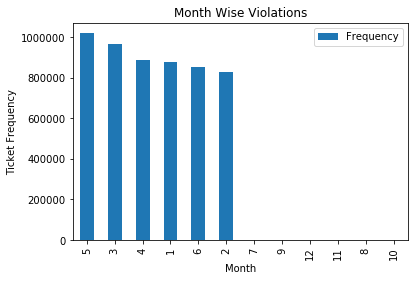

In [24]:
violation_count = violation.toPandas()
violation_count.plot(x= 'Month', y='Frequency', kind='bar')
plt.title("Month Wise Violations")
plt.xlabel('Month')
plt.ylabel('Ticket Frequency')
plt.show()

As per the above table and graph, we see that most number of violations occurred in below months:
 - May
 - March
 - April
 - January
 - June
 - February

##### Checking violations made by number plate:

In [25]:
number_plate = spark.sql("select Plate_ID, count(*) as Ticket_Frequency from nyc_table group by Plate_ID having Ticket_Frequency >= 500 order by Ticket_Frequency desc")
number_plate.show()

+----------+----------------+
|  Plate_ID|Ticket_Frequency|
+----------+----------------+
|BLANKPLATE|            5261|
|   96089MA|             529|
|   96087MA|             528|
|   94905JA|             527|
|   14828MJ|             526|
|   85848MD|             512|
|   30954JX|             510|
|   2121796|             507|
+----------+----------------+



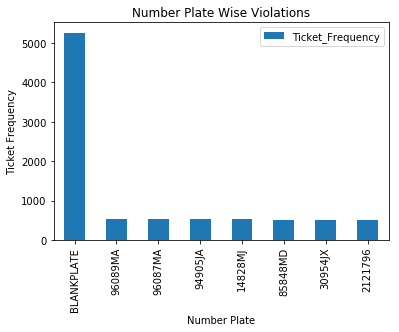

In [26]:
number_plate_violation = number_plate.toPandas()
number_plate_violation.plot(x= 'Plate_ID', y='Ticket_Frequency', kind='bar')
plt.title("Number Plate Wise Violations")
plt.xlabel('Number Plate')
plt.ylabel('Ticket Frequency')
plt.show()

As per the above table and graph, most number of violations are made by the **Blank Number Plates**.

##### Checking Violation and their counts:

In [27]:
violation_code = spark.sql("select Violation_Code, count(*) as Ticket_Frequency from nyc_table group by Violation_Code order by Ticket_Frequency desc limit 10")
violation_code.show()

+--------------+----------------+
|Violation_Code|Ticket_Frequency|
+--------------+----------------+
|            21|          768087|
|            36|          662765|
|            38|          542079|
|            14|          476664|
|            20|          319646|
|            46|          312330|
|            37|          293147|
|            40|          277184|
|            71|          263393|
|             7|          210176|
+--------------+----------------+



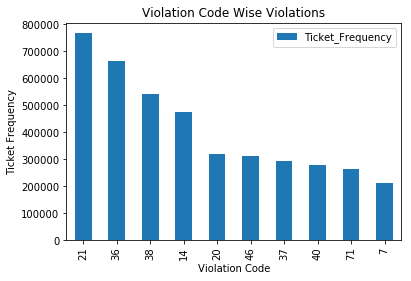

In [28]:
violation_code_count = violation_code.toPandas()
violation_code_count.plot(x= 'Violation_Code', y='Ticket_Frequency', kind='bar')
plt.title("Violation Code Wise Violations")
plt.xlabel('Violation Code')
plt.ylabel('Ticket Frequency')
plt.show()

As per the above table and plot, we see that below are the top 3 Violation Codes:
- Violation Code 21
- Violation Code 36
- Violation Code 38

## Examine the data:

### 1. Find the total number of tickets for the year.

In [29]:
spark.sql("select count(*) as Total_Tickets from nyc_table").show()

+-------------+
|Total_Tickets|
+-------------+
|      5431918|
+-------------+



So, there are total **5431918** parking violation tickets for the year 2017. It is a big number.

### 2. Find out the number of unique states from where the cars that got parking tickets came.

##### Let's print top few distinct records of the states:

In [30]:
df.select('Registration_State').distinct().show()

+------------------+
|Registration_State|
+------------------+
|                AZ|
|                SC|
|                NS|
|                LA|
|                MN|
|                NJ|
|                MX|
|                DC|
|                OR|
|                99|
|                NT|
|                VA|
|                RI|
|                WY|
|                KY|
|                BC|
|                NH|
|                MI|
|                GV|
|                NV|
+------------------+
only showing top 20 rows



We can see that there is record with value `99` in the state column which is not a valid value.
<br>Let's replace this value with the name of the state which occurred most of the time.

##### Checking States where most violations occurred:

In [31]:
states = spark.sql("select Registration_State, count(*) as Ticket_Frequency from nyc_table group by Registration_State order by Ticket_Frequency desc limit 5")
states.show()

+------------------+----------------+
|Registration_State|Ticket_Frequency|
+------------------+----------------+
|                NY|         4273951|
|                NJ|          475825|
|                PA|          140286|
|                CT|           70403|
|                FL|           69468|
+------------------+----------------+



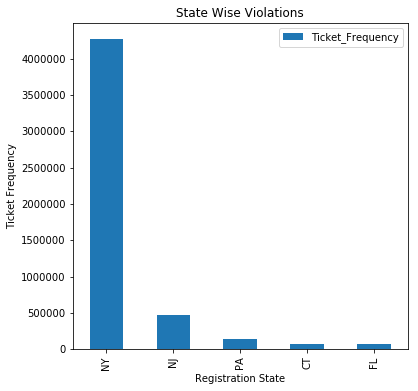

In [32]:
state_count = states.toPandas()
state_count.plot(x= 'Registration_State', y='Ticket_Frequency', kind='bar', figsize=(6,6))
plt.title("State Wise Violations")
plt.xlabel('Registration State')
plt.ylabel('Ticket Frequency')
plt.show()

As per the above data, below 3 states have most violation tickets:
- Ney York
- New Jersey
- Pennsylvania

##### Replacing `99` with `NY`:

In [33]:
df = df.withColumn('Registration_State', when(col('Registration_State') == '99', 'NY').otherwise(col('Registration_State')))

In [34]:
df.select('Registration_State').distinct().show()

+------------------+
|Registration_State|
+------------------+
|                AZ|
|                SC|
|                NS|
|                LA|
|                MN|
|                NJ|
|                MX|
|                DC|
|                OR|
|                NT|
|                VA|
|                RI|
|                WY|
|                KY|
|                BC|
|                NH|
|                MI|
|                GV|
|                NV|
|                QB|
+------------------+
only showing top 20 rows



## Aggregation tasks:

### 1. How often does each violation code occur? Display the frequency of the top five violation codes?

In [35]:
violation = spark.sql("select Violation_Code, count(*) as Frequency from nyc_table group by Violation_Code order by Frequency desc")
violation.show(5)

+--------------+---------+
|Violation_Code|Frequency|
+--------------+---------+
|            21|   768087|
|            36|   662765|
|            38|   542079|
|            14|   476664|
|            20|   319646|
+--------------+---------+
only showing top 5 rows



Top 5 Violation Codes are 21, 36, 38, 14 and 20.

### 2. How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? 

##### Grouping the data on the column "Vehicle_Body_Type" and calculate the aggregating count:

In [36]:
body_type = spark.sql("select Vehicle_Body_Type, count(*) as `Ticket Count for Vehicle Body Type` from nyc_table group by Vehicle_Body_Type order by `Ticket Count for Vehicle Body Type` desc")
body_type.show()

+-----------------+----------------------------------+
|Vehicle_Body_Type|Ticket Count for Vehicle Body Type|
+-----------------+----------------------------------+
|             SUBN|                           1883954|
|             4DSD|                           1547312|
|              VAN|                            724029|
|             DELV|                            358984|
|              SDN|                            194197|
|             PICK|                            135772|
|             2DSD|                            135707|
|             REFG|                             59641|
|             TRAC|                             40030|
|             TAXI|                             32608|
|             UTIL|                             31135|
|              BUS|                             24749|
|             4 DR|                             24153|
|             CONV|                             22064|
|             null|                             20196|
|         

As per the above data, below are the top 5 Vehicle Body Types which made most violations:
- SUBN
- 4DSD
- VAN
- DELV
- SDN

##### Grouping the data on the column "Vehicle_Make" and calculate the aggregating count:

In [37]:
make = spark.sql("select Vehicle_Make, count(*) as `Ticket Count for Vehicle make` from nyc_table group by Vehicle_Make order by `Ticket Count for Vehicle make` desc")
make.show()

+------------+-----------------------------+
|Vehicle_Make|Ticket Count for Vehicle make|
+------------+-----------------------------+
|        FORD|                       636844|
|       TOYOT|                       605291|
|       HONDA|                       538884|
|       NISSA|                       462017|
|       CHEVR|                       356032|
|       FRUEH|                       230787|
|       ME/BE|                       197568|
|       DODGE|                       187729|
|         BMW|                       186700|
|        JEEP|                       175815|
|       HYUND|                       148657|
|       INTER|                       128737|
|         GMC|                       127581|
|       LEXUS|                       122078|
|       ACURA|                       100637|
|       INFIN|                        88572|
|       CHRYS|                        85573|
|       VOLKS|                        85051|
|       SUBAR|                        71791|
|        A

As per the above data, below are the top 5 Vehicle Make companies which made most violations:
- FORD
- TOYOTA
- HONDA
- NISSAN
- CHEVROLET 

### 3. A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:

#### (i). 'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?

In [38]:
spark.sql("select Violation_Precinct, count(*) as `Ticket Count for Precinct` \
          from nyc_table \
          group by Violation_Precinct \
          order by `Ticket Count for Precinct` desc").show(6)

+------------------+-------------------------+
|Violation_Precinct|Ticket Count for Precinct|
+------------------+-------------------------+
|                 0|                   925596|
|                19|                   274445|
|                14|                   203553|
|                 1|                   174702|
|                18|                   169131|
|               114|                   147444|
+------------------+-------------------------+
only showing top 6 rows



#### (ii) 'Issuer Precinct' (This is the precinct that issued the ticket.)

In [39]:
spark.sql("select Issuer_Precinct, count(*) as `Ticket Count for Precinct Issuer` \
          from nyc_table \
          group by Issuer_Precinct \
          order by `Ticket Count for Precinct Issuer` desc").show(6)

+---------------+--------------------------------+
|Issuer_Precinct|Ticket Count for Precinct Issuer|
+---------------+--------------------------------+
|              0|                         1078406|
|             19|                          266961|
|             14|                          200495|
|              1|                          168740|
|             18|                          162994|
|            114|                          144054|
+---------------+--------------------------------+
only showing top 6 rows



#### Analysis:
- We see that first record of both the query results is 0. Hence, we displayed the top 6 records.
- As per the above both the tables, precincts 19, 14, 1, 18 amd 114 are common. However, violations are highest for `19`.

#### 4. Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?

From the above answer, it is noted that Top 3 Violation Precints are 14, 19 and 1. Let's calculate the Ticket counts foreach precincts using Group By:

##### Violation Codes count for Precincts 19:

In [40]:
spark.sql("select Violation_Code, count(*) as `Ticket Count for Precinct Zone 19` \
          from nyc_table \
          where Violation_Precinct = 19 \
          group by Violation_Code \
          order by `Ticket Count for Precinct Zone 19` desc limit 10").show()

+--------------+---------------------------------+
|Violation_Code|Ticket Count for Precinct Zone 19|
+--------------+---------------------------------+
|            46|                            50785|
|            38|                            37483|
|            37|                            36468|
|            14|                            30376|
|            21|                            29415|
|            20|                            15132|
|            40|                            11519|
|            16|                            10006|
|            71|                             7567|
|            19|                             7066|
+--------------+---------------------------------+



##### Violation Codes count for Precincts 14:

In [41]:
spark.sql("select Violation_Code, count(*) as `Ticket Count for Precinct Zone 14` \
          from nyc_table \
          where Violation_Precinct = 14 \
          group by Violation_Code \
          order by `Ticket Count for Precinct Zone 14` desc limit 10").show()

+--------------+---------------------------------+
|Violation_Code|Ticket Count for Precinct Zone 14|
+--------------+---------------------------------+
|            14|                            45885|
|            69|                            30465|
|            31|                            22649|
|            47|                            18691|
|            42|                            10027|
|            46|                             8411|
|            19|                             7455|
|            84|                             6749|
|            82|                             5052|
|            40|                             3654|
+--------------+---------------------------------+



##### Violation Codes count for Precincts 1:

In [42]:
spark.sql("select Violation_Code, count(*) as `Ticket Count for Precinct Zone 1` \
          from nyc_table \
          where Violation_Precinct = 1 \
          group by Violation_Code \
          order by `Ticket Count for Precinct Zone 1` desc limit 10").show()

+--------------+--------------------------------+
|Violation_Code|Ticket Count for Precinct Zone 1|
+--------------+--------------------------------+
|            14|                           40226|
|            16|                           19278|
|            20|                           15743|
|            46|                           13534|
|            38|                            8588|
|            17|                            7755|
|            37|                            6484|
|            19|                            6184|
|            31|                            6064|
|            69|                            5682|
+--------------+--------------------------------+



#### Analysis:
- There are many Violation codes are common for all the 3 precincts.
- The Violation Code `14` is the one which is common in all with highest violation tickets.

### 5. Find out the properties of parking violations across different times of the day:

#### (i) Find a way to deal with missing values, if any:

##### Checking Null Values in the dataframe using pyspark.sql:

In [43]:
null_count = spark.sql("select count(*) as `Total Null` \
                       from nyc_table \
                       where Summons_Number is null \
                       or Plate_ID is null \
                       or Registration_State is null \
                       or Issue_Date is null \
                       or Violation_Code is null \
                       or Vehicle_Body_Type is null \
                       or Vehicle_Make is null \
                       or Violation_Precinct is null \
                       or Issuer_Precinct is null \
                       or Violation_Time is null")
null_count.show()

+----------+
|Total Null|
+----------+
|     52748|
+----------+



There are total **52748** Null Values. Lets' handle this.

##### Dropping Null Values:

In [44]:
df = df.na.drop()

##### Creataing a view on this clean dataframe:

In [45]:
df.createOrReplaceTempView('nyc_table')

##### Again calculating the Null Values in complete dataframe:

In [46]:
null_count = spark.sql("select count(*) as `Total Null` \
                       from nyc_table \
                       where Summons_Number is null \
                       or Plate_ID is null \
                       or Registration_State is null \
                       or Issue_Date is null \
                       or Violation_Code is null \
                       or Vehicle_Body_Type is null \
                       or Vehicle_Make is null \
                       or Violation_Precinct is null \
                       or Issuer_Precinct is null \
                       or Violation_Time is null")
null_count.show()

+----------+
|Total Null|
+----------+
|         0|
+----------+



Now, there is **0** null value.

#### (ii) The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

Let's first display the Violation_Time column to get an idea about its format:

In [47]:
spark.sql("select Violation_Time, count(*) as `Total Parking Violation` \
          from nyc_table \
          group by Violation_Time \
          order by `Total Parking Violation` desc").show()

+--------------+-----------------------+
|Violation_Time|Total Parking Violation|
+--------------+-----------------------+
|         0836A|                  28282|
|         1136A|                  26805|
|         1140A|                  26757|
|         0936A|                  25105|
|         0840A|                  24920|
|         0940A|                  24885|
|         0906A|                  24729|
|         1145A|                  24087|
|         0945A|                  23912|
|         1138A|                  23597|
|         0845A|                  23532|
|         1142A|                  23463|
|         0910A|                  23426|
|         1139A|                  23246|
|         0806A|                  23044|
|         1137A|                  23006|
|         0839A|                  22937|
|         1141A|                  22909|
|         0837A|                  22900|
|         0938A|                  22896|
+--------------+-----------------------+
only showing top

##### Validating the value of `Vioaltion_Time` with `RegEx` expression using `rlike` function:
Creating one boolean column `Acceptable` and setting a criteria for valid time: 

In [48]:
df.select('Violation_Time', col('Violation_Time').rlike('^[01][0-9]{3}[AP]$').alias('Acceptable')).filter(col('Acceptable') == 'false').show()

+--------------+----------+
|Violation_Time|Acceptable|
+--------------+----------+
|         4733P|     false|
|         084/A|     false|
|         2959P|     false|
|         6815P|     false|
|         0.22A|     false|
|          1237|     false|
|          0557|     false|
|         110+A|     false|
|         093+A|     false|
|         8715P|     false|
|         4930P|     false|
|         5402P|     false|
|          1047|     false|
|          0855|     false|
|         5857P|     false|
|         075/P|     false|
|         6820P|     false|
|         09.5A|     false|
|         3028P|     false|
|          1145|     false|
+--------------+----------+
only showing top 20 rows



We can see that above time format is really weird. We'll handle the discrepancy soon.


##### Checking total number of such records where violation time does not match the criteria:

In [49]:
df.select('Violation_Time', col('Violation_Time').rlike('^[01][0-9]{3}[AP]$').alias('Acceptable')).filter(col('Acceptable') == 'false').count()

158

So, there are total **158** records are not in proper time criteria.

##### Creating the column 'Acceptable'  and saving the dataframe in a new dataframe:

In [50]:
df1 = df.withColumn('Acceptable', col('Violation_Time').rlike('^[01][0-9]{3}[AP]$'))
df1.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+----------+
|Summons_Number|Plate_ID|Registration_State|         Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|Acceptable|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+----------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|      true|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|      true|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|           

Now, we have an option to drop these 158 records which don't have proper format. However, instead of doing that let's replace these values with a general value `0000A`.

##### Creating a new DF which takes values as per the mentioned criteria:

In [51]:
df2 = df1.withColumn('Violation_Time', when(col('Acceptable') == 'false', lit('0000A')).otherwise(df1.Violation_Time))

##### Let's see the effect of imputation of the time format:

In [52]:
df2.select('Violation_Time', 'Acceptable').filter(col('Acceptable') == 'false').show()

+--------------+----------+
|Violation_Time|Acceptable|
+--------------+----------+
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
|         0000A|     false|
+--------------+----------+
only showing top 20 rows



We see that all the 'false' values got repalced by **0000A** now.

##### Re-checking the Violation_Time and Acceptable colums which are not in mentioned criteria:

In [53]:
df2.select('Violation_Time', col('Violation_Time').rlike('^[01][0-9]{3}[AP]$').alias('Acceptable')).filter(col('Acceptable') == 'false').show()
df2.select('Violation_Time', col('Violation_Time').rlike('^[01][0-9]{3}[AP]$').alias('Acceptable')).filter(col('Acceptable') == 'false').count()

+--------------+----------+
|Violation_Time|Acceptable|
+--------------+----------+
+--------------+----------+



0

We see that the count is 0 now. It means, all the values of the column "Violation_Time" are in proper criteria.
<br>However, these timings are still not in any clock format. Let's convert these in proper format using **User Defined Function (UDF)**.

##### Importing StringType and UDF libraries:

In [54]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

##### Creating 2 UDF functions `convert_udf1` and `convert_udf2`. Below are the description of both:
- **convert_udf1:** Separates hour, minute and second. Also, converts the time in **24 Hour format**.
- **convert_udf2:** If there is a value as **24** in hour part, converts it to **00**.

In [55]:
convert_udf1 = udf(lambda x : x[0:2] + ':' + x[2:4] + ':' + '00' if x[-1] == 'A' or int(x[0:2]) in range(13, 25) else str(int(x[0:2]) +12) + ':' + x[2:4] + ':' + '00', StringType())
convert_udf2 = udf(lambda x : '00' + x[2:] if x[0:2] == '24' else x)

df2 = df2.withColumn('Violation_Time', convert_udf1('Violation_Time'))
df2 = df2.withColumn('Violation_Time', convert_udf2('Violation_Time'))

##### Let's check the new format of the Violation_Time column:

In [56]:
df2.select('Violation_Time').show()

+--------------+
|Violation_Time|
+--------------+
|      01:43:00|
|      16:00:00|
|      14:33:00|
|      11:20:00|
|      17:55:00|
|      20:52:00|
|      02:15:00|
|      07:58:00|
|      10:05:00|
|      08:45:00|
|      00:15:00|
|      07:07:00|
|      10:22:00|
|      11:50:00|
|      05:25:00|
|      18:45:00|
|      11:22:00|
|      14:56:00|
|      12:32:00|
|      10:34:00|
+--------------+
only showing top 20 rows



It's good to see that now timings are in proper clock format.

#### (iii) Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.

##### Let's create a new view 'bin_table' for further processing:

In [57]:
df2.createOrReplaceTempView('bin_table')

##### Converting Timings in total 6 bins and saving the result in a new DF `bins`:

In [58]:
bins = spark.sql("select Violation_Code, count(*) as `Number of Violation Tickets`, \
                  CASE \
                  WHEN HOUR(Violation_Time) between 0 and 3 THEN '1' \
                  WHEN HOUR(Violation_Time) between 4 and 7 THEN '2' \
                  WHEN HOUR(Violation_Time) between 8 and 11 THEN '3' \
                  WHEN HOUR(Violation_Time) between 12 and 15 THEN '4' \
                  WHEN HOUR(Violation_Time) between 16 and 19 THEN '5' \
                  WHEN HOUR(Violation_Time) between 20 and 23 THEN '6' \
                  END as `Violation Time Bin` \
                  from bin_table group by `Violation Time Bin`, violation_code")
bins.show()

+--------------+---------------------------+------------------+
|Violation_Code|Number of Violation Tickets|Violation Time Bin|
+--------------+---------------------------+------------------+
|            61|                        962|                 1|
|            15|                          2|                 5|
|            40|                      47424|                 5|
|            74|                      14276|                 5|
|            74|                      28538|                 4|
|            41|                       1905|                 3|
|             6|                        129|                 6|
|            23|                       1770|                 1|
|            72|                        921|                 2|
|             1|                        263|                 4|
|            94|                         16|                 2|
|            42|                         80|                 2|
|            84|                      18

##### Creating new View `bins_table` using the above result:

In [59]:
bins.createOrReplaceTempView('bins_table')

##### Let's calculate the bin wise most three common violations on the basis of above table:

##### Bin 1:

In [60]:
bin1 = spark.sql("select Violation_Code from bins_table where `Violation Time Bin` == 1 group by Violation_Code order by count(*) desc")
bin1.show(3)

+--------------+
|Violation_Code|
+--------------+
|            53|
|            85|
|            65|
+--------------+
only showing top 3 rows



##### Bin 2:

In [61]:
bin2 = spark.sql("select Violation_Code from bins_table where `Violation Time Bin` == 2 group by Violation_Code order by count(*) desc")
bin2.show(3)

+--------------+
|Violation_Code|
+--------------+
|            31|
|            53|
|            65|
+--------------+
only showing top 3 rows



In [62]:
bin3 = spark.sql("select Violation_Code from bins_table where `Violation Time Bin` == 3 group by Violation_Code order by count(*) desc")
bin3.show(3)

+--------------+
|Violation_Code|
+--------------+
|            85|
|            31|
|            53|
+--------------+
only showing top 3 rows



In [63]:
bin4 = spark.sql("select Violation_Code from bins_table where `Violation Time Bin` == 4 group by Violation_Code order by count(*) desc")
bin4.show(3)

+--------------+
|Violation_Code|
+--------------+
|            85|
|            31|
|            78|
+--------------+
only showing top 3 rows



In [64]:
bin5 = spark.sql("select Violation_Code from bins_table where `Violation Time Bin` == 5 group by Violation_Code order by count(*) desc")
bin5.show(3)

+--------------+
|Violation_Code|
+--------------+
|            53|
|            31|
|            65|
+--------------+
only showing top 3 rows



#### (iv) Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).

In [66]:
time_bin = spark.sql("select `Violation Time Bin`, count(*) as `Total Violation` from bins_table group by `Violation Time Bin` order by `Total Violation` desc")
time_bin.show(3)

+------------------+---------------+
|Violation Time Bin|Total Violation|
+------------------+---------------+
|                 3|             99|
|                 4|             99|
|                 1|             97|
+------------------+---------------+
only showing top 3 rows



Bins 3, 4 and 1 are having most violations

### 6. Let’s try and find some seasonality in this data:

#### (i) First, divide the year into a certain number of seasons and find the frequencies of tickets for each season.

##### Let's create a ne table `season_table`:

In [67]:
df2.createOrReplaceTempView('season_table')

##### Using the column `Issue_Date` and dividing the year into 4 seasons as per below details:
- **Spring:** March, April, May
- **Summer:** June, July, August
- **Autumn:** September. October, November
- **Winter:** December, January, February

In [68]:
season = spark.sql("select Violation_Code, month(Issue_Date) as Month, \
          CASE \
          WHEN month(Issue_Date) between 3 and 5 THEN 'Spring' \
          WHEN month(Issue_Date) between 6 and 8 THEN 'Summer' \
          WHEN month(Issue_Date) between 9 and 11 THEN 'Autumn' \
          WHEN month(Issue_Date) in (1, 2, 12) THEN 'Winter' \
          END as Season \
          from season_table")
season.show()

+--------------+-----+------+
|Violation_Code|Month|Season|
+--------------+-----+------+
|             7|    7|Summer|
|             7|    7|Summer|
|             5|    8|Summer|
|            47|    6|Summer|
|            69|   11|Autumn|
|             7|    6|Summer|
|            40|    8|Summer|
|            36|   12|Winter|
|            36|   11|Autumn|
|             5|   10|Autumn|
|            78|    1|Winter|
|            19|    9|Autumn|
|            36|   10|Autumn|
|            21|    9|Autumn|
|            40|    2|Winter|
|            71|    7|Summer|
|             7|    9|Autumn|
|            64|    1|Winter|
|            20|    4|Spring|
|            36|    2|Winter|
+--------------+-----+------+
only showing top 20 rows



##### Creating a new table view `seasonality_table` on the basis of above table:

In [69]:
season.createOrReplaceTempView('seasonality_table')

##### Now, let's calculate the season wise total violations and infer the result:

In [70]:
spark.sql("select Season, count(*) as `Total Violation` from seasonality_table group by Season order by `Total Violation` desc").show()

+------+---------------+
|Season|Total Violation|
+------+---------------+
|Spring|        2850576|
|Autumn|        2807007|
|Summer|        2580599|
|Winter|        2459993|
+------+---------------+



As per the above analysis, we see that most number of violation occurred during Summer. There mat=y be a reason that most of the people go for outing during summer vacation and it creates a parking problem in few regions.

#### (ii) Find the three most common violations for each of these seasons.

##### Spring:

In [71]:
spring = spark.sql("select Violation_Code, count(*) as `Total Violations in Spring` from seasonality_table where Season = 'Spring' group by Violation_Code order by `Total Violations in Spring` desc")
spring.show(3)

+--------------+--------------------------+
|Violation_Code|Total Violations in Spring|
+--------------+--------------------------+
|            21|                    398203|
|            36|                    344366|
|            38|                    270084|
+--------------+--------------------------+
only showing top 3 rows



##### Summer:

In [72]:
summer = spark.sql("select Violation_Code, count(*) as `Total Violations in Summer` from seasonality_table where Season = 'Summer' group by Violation_Code order by `Total Violations in Summer` desc")
summer.show(3)

+--------------+--------------------------+
|Violation_Code|Total Violations in Summer|
+--------------+--------------------------+
|            21|                    401572|
|            38|                    247074|
|            36|                    240065|
+--------------+--------------------------+
only showing top 3 rows



##### Autumn:

In [73]:
autumn = spark.sql("select Violation_Code, count(*) as `Total Violations in Autumn` from seasonality_table where Season = 'Autumn' group by Violation_Code order by `Total Violations in Autumn` desc")
autumn.show(3)

+--------------+--------------------------+
|Violation_Code|Total Violations in Autumn|
+--------------+--------------------------+
|            36|                    455426|
|            21|                    353670|
|            38|                    283591|
+--------------+--------------------------+
only showing top 3 rows



##### Winter:

In [74]:
winter = spark.sql("select Violation_Code, count(*) as `Total Violations in Winter` from seasonality_table where Season = 'Winter' group by Violation_Code order by `Total Violations in Winter` desc")
winter.show(3)

+--------------+--------------------------+
|Violation_Code|Total Violations in Winter|
+--------------+--------------------------+
|            36|                    358842|
|            21|                    358131|
|            38|                    259106|
+--------------+--------------------------+
only showing top 3 rows



#### Descripton:
As per the above analysis, it is found that the violation codes **36**, **21** and **38** are most common across all the sesons.

### 7. The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:

#### (i) Find the total occurrences of the three most common violation codes:

In [75]:
most_common_violation = spark.sql("select Violation_Code, count(*) as `Total Violations` from nyc_table group by Violation_Code order by `Total Violations` desc")
most_common_violation.show(3)

+--------------+----------------+
|Violation_Code|Total Violations|
+--------------+----------------+
|            21|         1511576|
|            36|         1398699|
|            38|         1059855|
+--------------+----------------+
only showing top 3 rows



So, violation codes **36**, **21** and **38** are most common.

#### (ii) Then, visit the website: http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page . It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.

So, most occurred violation code is **21**. 
As per the above site, the fine for this violation code is USD 65.
As per the above site, it is found that the fine for both highest-density locations and other locations is same $65.

In [76]:
collected_fine = most_common_violation.withColumn('Fine', when(col('Violation_Code') == 21, col('Total Violations') * 65) \
                                                 .otherwise(col('Total Violations') * 65))
collected_fine.show(3)

+--------------+----------------+--------+
|Violation_Code|Total Violations|    Fine|
+--------------+----------------+--------+
|            21|         1511576|98252440|
|            36|         1398699|90915435|
|            38|         1059855|68890575|
+--------------+----------------+--------+
only showing top 3 rows



##### Printing total fine collected:

In [77]:
print("Total Fine Collected for 3 most common violations: ", 49925655 + 43079725 + 35235135)

Total Fine Collected for 3 most common violations:  128240515


#### Conclusion:
- Most number of violations occurred during summer. This is expected behavior because most of the people go for outing during summer vacation and they have to find place for the parking in a dense region where already a lot of people parked their vehicles.
- The Violation Code **21** is the most occurring violation which denotes "No parking where parking is not allowed by sign, street marking or traffic control device".
- Time windows which fall under the bins 3, 4, 1 have most violations.
- Precinct Zone 19, 14 and 1 have highest violations.
- New York has most number of parking violation issue.
- Parking is really a big problem and due to huge violations, NY police had collected total fine of 128240515 $.

##### Stopping the spark session:

In [78]:
spark.stop()